In [1]:
library(tidyverse)
library(sva)
library(edgeR)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.

Loading required package: genefilter


Attaching package: ‘genefilter’


The following object is masked from ‘package:readr’:

    spec


Loading required package: BiocParallel

Loading required package: limma



# Plots

In [2]:
pca_plot <- function(df, batch_info, title, path) {
  pca <- prcomp(t(na.omit(df)))
  # Plot PCA
  pca_df <-
    pca$x %>%
    as.data.frame() %>%
    rownames_to_column("sample_id") %>% 
    left_join(batch_info,  by = "sample_id") 
  # add % of explained variance
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))
  # Add the label for the specific point
  pca_plot <- pca_df %>%
    ggplot(aes(PC1, PC2)) +
    geom_point(aes(col=is_LumA, shape=lab), size=2) +
    theme_classic() +
    labs(title = title,
         x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
         y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]"))

  if(path != "") {ggsave(path, pca_plot)}
  return(pca_plot)
}

In [3]:
# boxplot
boxplot_pg <- function(matrix, title, path) {
  # Reshape data into long format
  long_data <- tidyr::gather(matrix, 
                             key = "sample_id", value = "Intensity")
  # Log tranformed scale
  boxplot <- ggplot(long_data, aes(x = sample_id, y = Intensity)) + 
    geom_boxplot() +
    stat_summary(fun = mean, geom = "point", shape = 4, size = 1.5, color = "red") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 5)) +
    labs(title = title) 

  if(path != "") {ggsave(path, boxplot, width = 6, height = 6)}
  return(boxplot)
}

In [4]:
heatmap_plot <- function(matrix, batch_info, name, plot_name_prefix){
    cor_matrix <- cor(na.omit(matrix), use = "pairwise.complete.obs")
    pheatmap::pheatmap(cor_matrix, 
                        annotation_col = select(batch_info, c(is_LumA, lab)),
                        treeheight_row = 0, treeheight_col = 0, 
                        fontsize_row = 5, fontsize_col = 5,
                        width = 7, height = 7,
                        main = paste0(name, ' heatmap')
                        )
}


# Load data

In [23]:
labs_list = c('GSE129508', 'GSE149276', 'GSE58135')  
data_matrix <- NULL
meta_info <- NULL

for (name in labs_list) {
  file_name_prefix <- paste0('/home/yuliya/repos/cosybio/removeBatch/test_data/counts/')

  if(is.null(data_matrix)){
    data_matrix <- read.csv(paste0(file_name_prefix, 'raw/', name, '.counts.tsv'), check.names = FALSE, sep="\t") 
    meta_info <- read.csv(paste0(file_name_prefix, name, '.sample_info.tsv'), check.names = FALSE, sep="\t")
    # add new column with name
    meta_info$lab <- name
  } else {
    data_matrix <- full_join(data_matrix, 
                       read.csv(paste0(file_name_prefix, 'raw/', name, '.counts.tsv'), check.names = FALSE, sep="\t"),
                       by = "gene_id")
    meta_info <- rbind(meta_info, read.csv(paste0(file_name_prefix, name, '.sample_info.tsv'), check.names = FALSE, sep="\t") %>% mutate(lab = name))
  }
}

rownames(meta_info) <- meta_info$sample_id
meta_info <- meta_info %>% mutate(is_LumA = as.factor(is_LumA), lab = as.factor(lab))
data_matrix <- data_matrix %>% column_to_rownames("gene_id")
#data_matrix <- data_matrix[, rownames(meta_info)]

meta_plots <- meta_info

In [6]:
dim(data_matrix)
head(data_matrix)

[1] 35238   132

,GSM3714577,GSM3714579,GSM3714581,GSM3714585,GSM3714587,GSM3714589,GSM3714591,GSM3714595,GSM3714597,GSM3714599,⋯,GSM1401714,GSM1401725,GSM1401692,GSM1401689,GSM1401752,GSM1401719,GSM1401736,GSM1401744,GSM1401681,GSM1401723
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
A1BG,363,732,650,379,912,98,376,88,506,184,⋯,1914,425,1051,1034,2422,1147,634,2498,1179,760
A1CF,5,16,0,7,15,0,3,4,2,10,⋯,110,9,33,38,205,76,26,83,26,41
A2M,19059,16821,15554,14844,31897,10656,15895,32102,26985,20846,⋯,5048,11582,16842,19400,1912,4247,48515,18468,2978,256904
A2ML1,52,31,11,44,101,64,121,62,51,1300,⋯,1218,4266,219,141,248,933,9083,793,121,291
A2MP1,1,0,0,0,1,0,0,0,1,0,⋯,39,8,34,74,19,14,21,19,6,67
A3GALT2,1,0,2,1,7,0,1,1,3,2,⋯,43,9,6,11,23,63,9,34,6,12


In [7]:
dim(meta_info)
head(meta_info)

[1] 132   5

,sample_id,Lum,Basal,is_LumA,lab
,<chr>,<int>,<int>,<fct>,<fct>
GSM3714577,GSM3714577,1,0,1,GSE129508
GSM3714579,GSM3714579,1,0,0,GSE129508
GSM3714581,GSM3714581,1,0,0,GSE129508
GSM3714585,GSM3714585,1,0,1,GSE129508
GSM3714587,GSM3714587,1,0,1,GSE129508
GSM3714589,GSM3714589,1,0,0,GSE129508


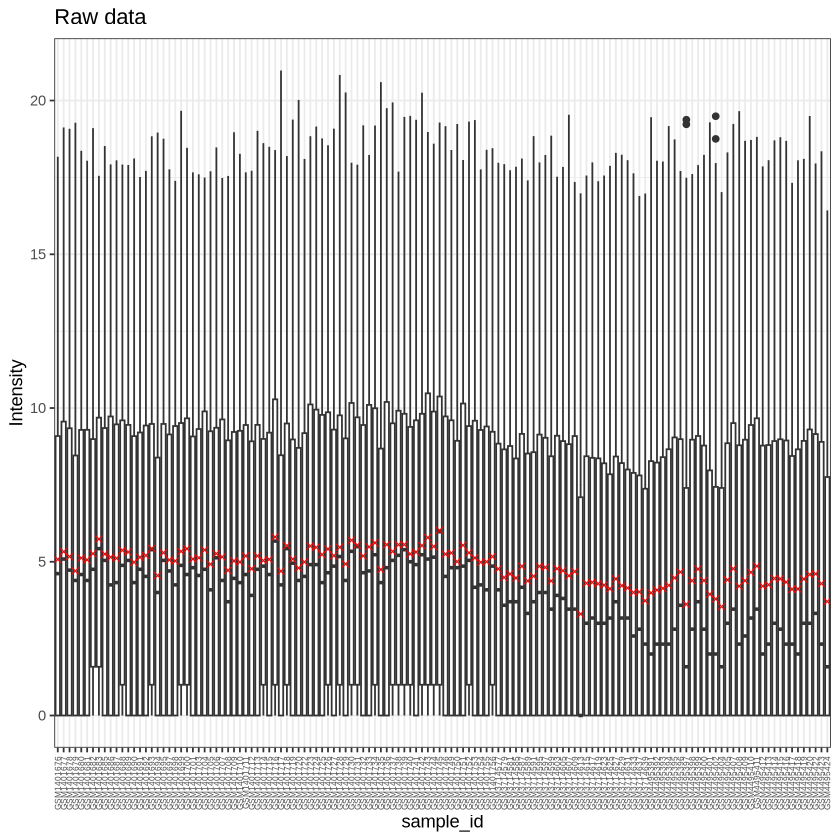

In [8]:
# select 5000 random rows from data matrix and plot them
set.seed(123)
boxplot_pg(log2(data_matrix[sample(nrow(data_matrix), 5000),] + 1), "Raw data", "")

# Script correction

In [9]:
group1 <- "Lum" 
group2 <- "Basal"
covars <- c(group1, group2, "is_LumA", "lab") 

batch <- as.numeric(as.factor(meta_info$lab)) - 1
head(meta_info ,3)

meta_info <- meta_info[,covars]
group <- meta_info[,group1]


,sample_id,Lum,Basal,is_LumA,lab
,<chr>,<int>,<int>,<fct>,<fct>
GSM3714577,GSM3714577,1,0,1,GSE129508
GSM3714579,GSM3714579,1,0,0,GSE129508
GSM3714581,GSM3714581,1,0,0,GSE129508


In [10]:
group

[1] 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0
 [38] 1 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1
 [75] 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 1
[112] 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0

In [11]:
raw_exprs <- DGEList(data_matrix)

# normalize 
all_groups <- c(group1, group2)
group = as.factor(apply(meta_info[, all_groups], 1, function(x) {
  all_groups[as.logical(x)]
}))
keep_exprs <- filterByExpr(raw_exprs, group=group)

cat(paste0("Genes passed filterByExprs: ",length(keep_exprs[keep_exprs])))
raw_exprs_filtered <- raw_exprs[keep_exprs,, keep.lib.sizes=FALSE]

raw_exprs <- calcNormFactors(raw_exprs_filtered, method = "upperquartile") # TMM

raw_exprs_normalized <- cpm(raw_exprs, log=TRUE)
head(raw_exprs_normalized, 3)

Genes passed filterByExprs: 19861

,GSM3714577,GSM3714579,GSM3714581,GSM3714585,GSM3714587,GSM3714589,GSM3714591,GSM3714595,GSM3714597,GSM3714599,⋯,GSM1401714,GSM1401725,GSM1401692,GSM1401689,GSM1401752,GSM1401719,GSM1401736,GSM1401744,GSM1401681,GSM1401723
A1BG,3.427972,4.6818628,4.394393,4.032185,4.661398,1.935841,3.785306,1.127351,3.705522,2.864899,⋯,6.021296,2.689867,4.4189874,4.475718,5.965890,5.334068,3.044363,5.466796,4.7461815,3.4646067
A1CF,-2.334306,-0.7115367,-4.300637,-1.506405,-1.101217,-4.300637,-2.640736,-2.758910,-3.291839,-1.171689,⋯,1.918648,-2.424217,-0.4722795,-0.206615,2.415998,1.443697,-1.369657,0.602655,-0.6405645,-0.6358548
A2M,9.135644,9.2014082,8.971756,9.319356,9.786829,8.681425,9.181809,9.604483,9.436882,9.678825,⋯,7.419717,7.447174,8.4180041,8.702348,5.625086,7.221321,9.293383,8.351546,6.0813127,11.8589939


In [12]:
adjusted_counts <- ComBat_seq(data_matrix, batch=batch, group=group, full_mod=TRUE)
head(adjusted_counts, 3)

In [ ]:
adjusted_exprs <- DGEList(adjusted_counts)

# normalize 
all_groups <- c(group1, group2)
group = as.factor(apply(meta_info[, all_groups], 1, function(x) {
  all_groups[as.logical(x)]
}))
keep_exprs <- filterByExpr(adjusted_exprs, group=group)

cat(paste0("Genes passed filterByExprs: ",length(keep_exprs[keep_exprs])))
adjusted_exprs_filtered <- adjusted_exprs[keep_exprs,, keep.lib.sizes=FALSE]

adjusted_exprs <- calcNormFactors(adjusted_exprs_filtered, method = "upperquartile") # TMM

adjusted_exprs_normalized <- cpm(adjusted_exprs, log=TRUE)
head(adjusted_exprs_normalized, 3)

Genes passed filterByExprs: 18952

,GSM1401701,GSM1401724,GSM1401678,GSM1401710,GSM1401743,GSM1401726,GSM1401742,GSM1401755,GSM1401730,GSM1401708,⋯,GSM4495414,GSM4495415,GSM4495416,GSM4495417,GSM4495418,GSM4495419,GSM4495420,GSM4495422,GSM4495423,GSM4495424
A1BG,5.5735366,3.092999,4.5924722,4.249401,2.179190,2.231161,3.6682813,3.881363,3.186834,4.6148322,⋯,4.278609,3.7951405,4.267944,3.815113,4.350518,5.030383,5.233188,5.705684,4.510052,3.434315
A1CF,0.6707498,-1.779464,-0.3102936,-1.166275,-1.694647,-2.132968,-0.8177619,-1.688727,-1.294504,-0.8448608,⋯,-1.050809,0.5907245,-1.651050,-1.171776,-1.409394,-1.600900,-1.887820,-1.291976,-1.675408,-2.641096
A2M,7.2421978,11.511196,8.6982033,9.764282,8.684890,8.156205,10.4921890,7.334736,7.982825,7.8239895,⋯,9.796217,8.0669607,8.783791,9.893966,8.337191,8.345032,7.838419,9.214834,11.638635,8.779297


## Plots

### before

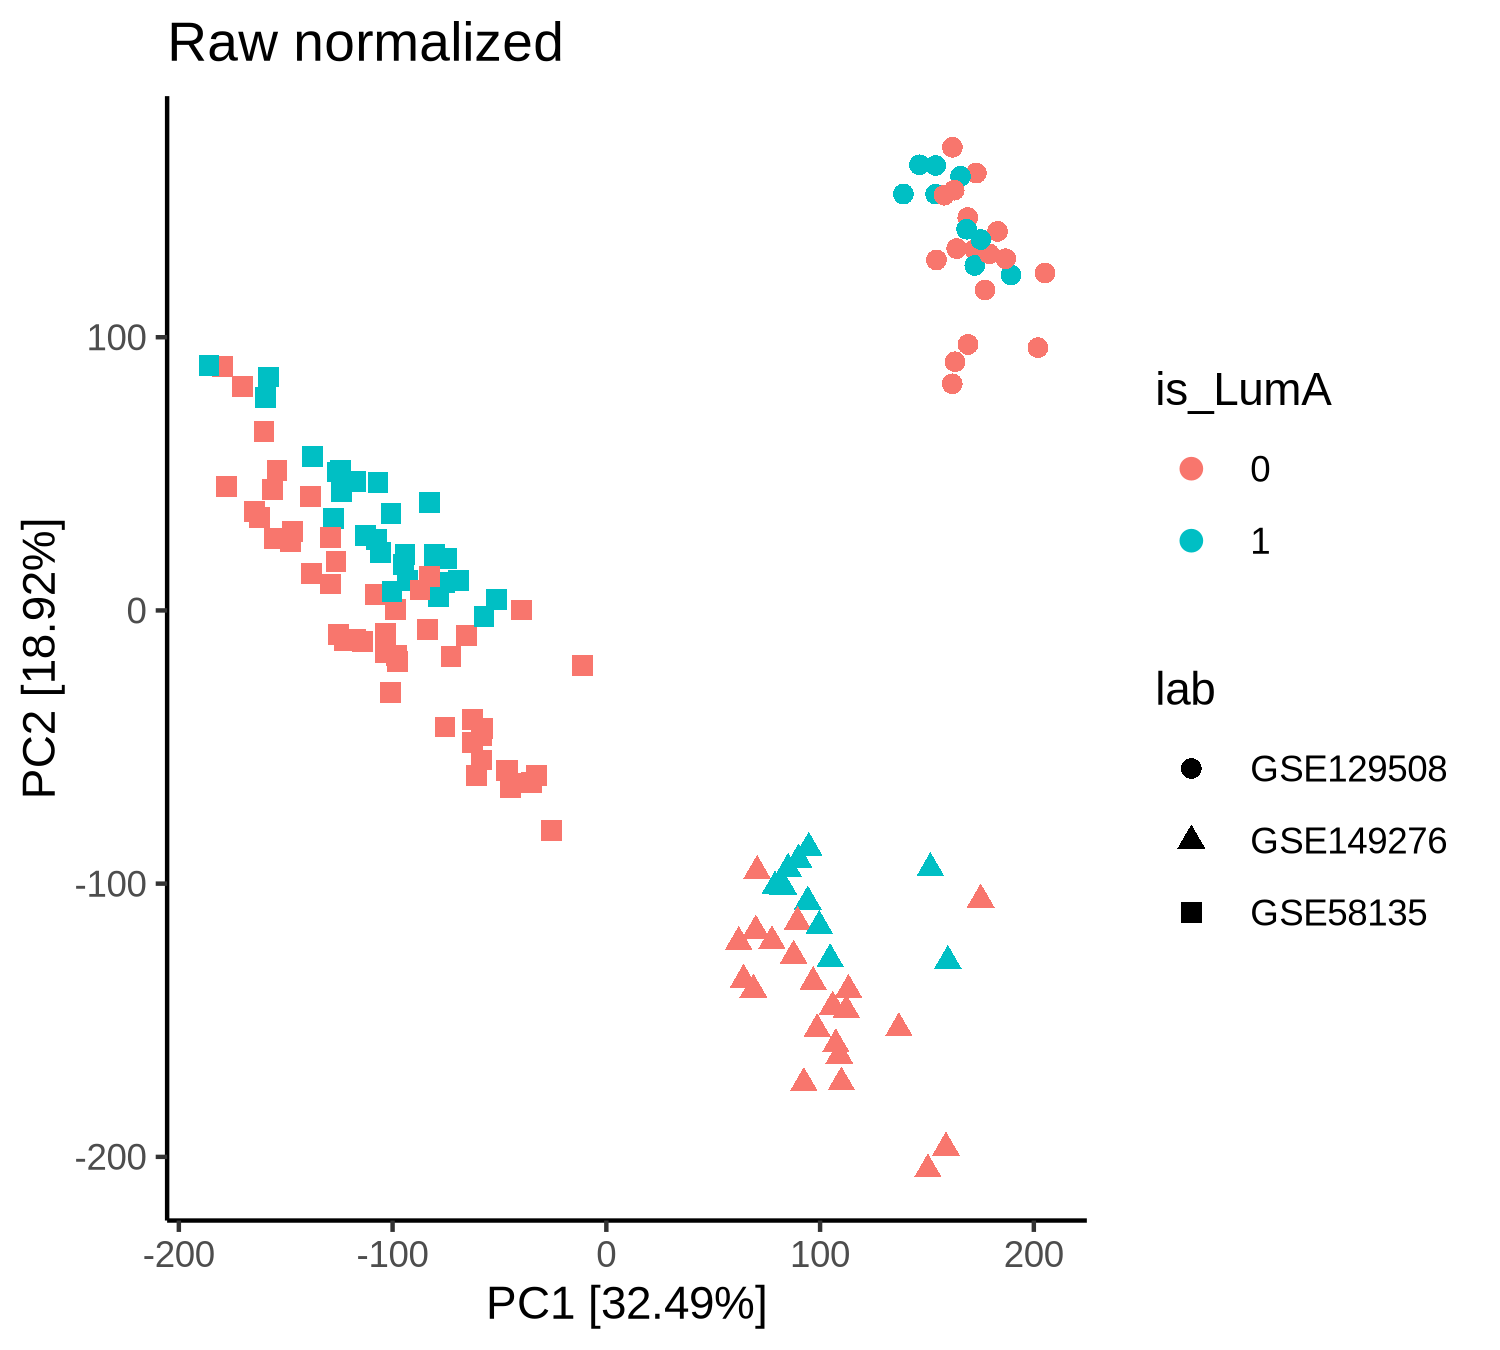

In [ ]:
# raw normalized
options(repr.plot.width =  5, repr.plot.height = 4.5)
pca_plot(raw_exprs_normalized, meta_plots, "Raw normalized", "")

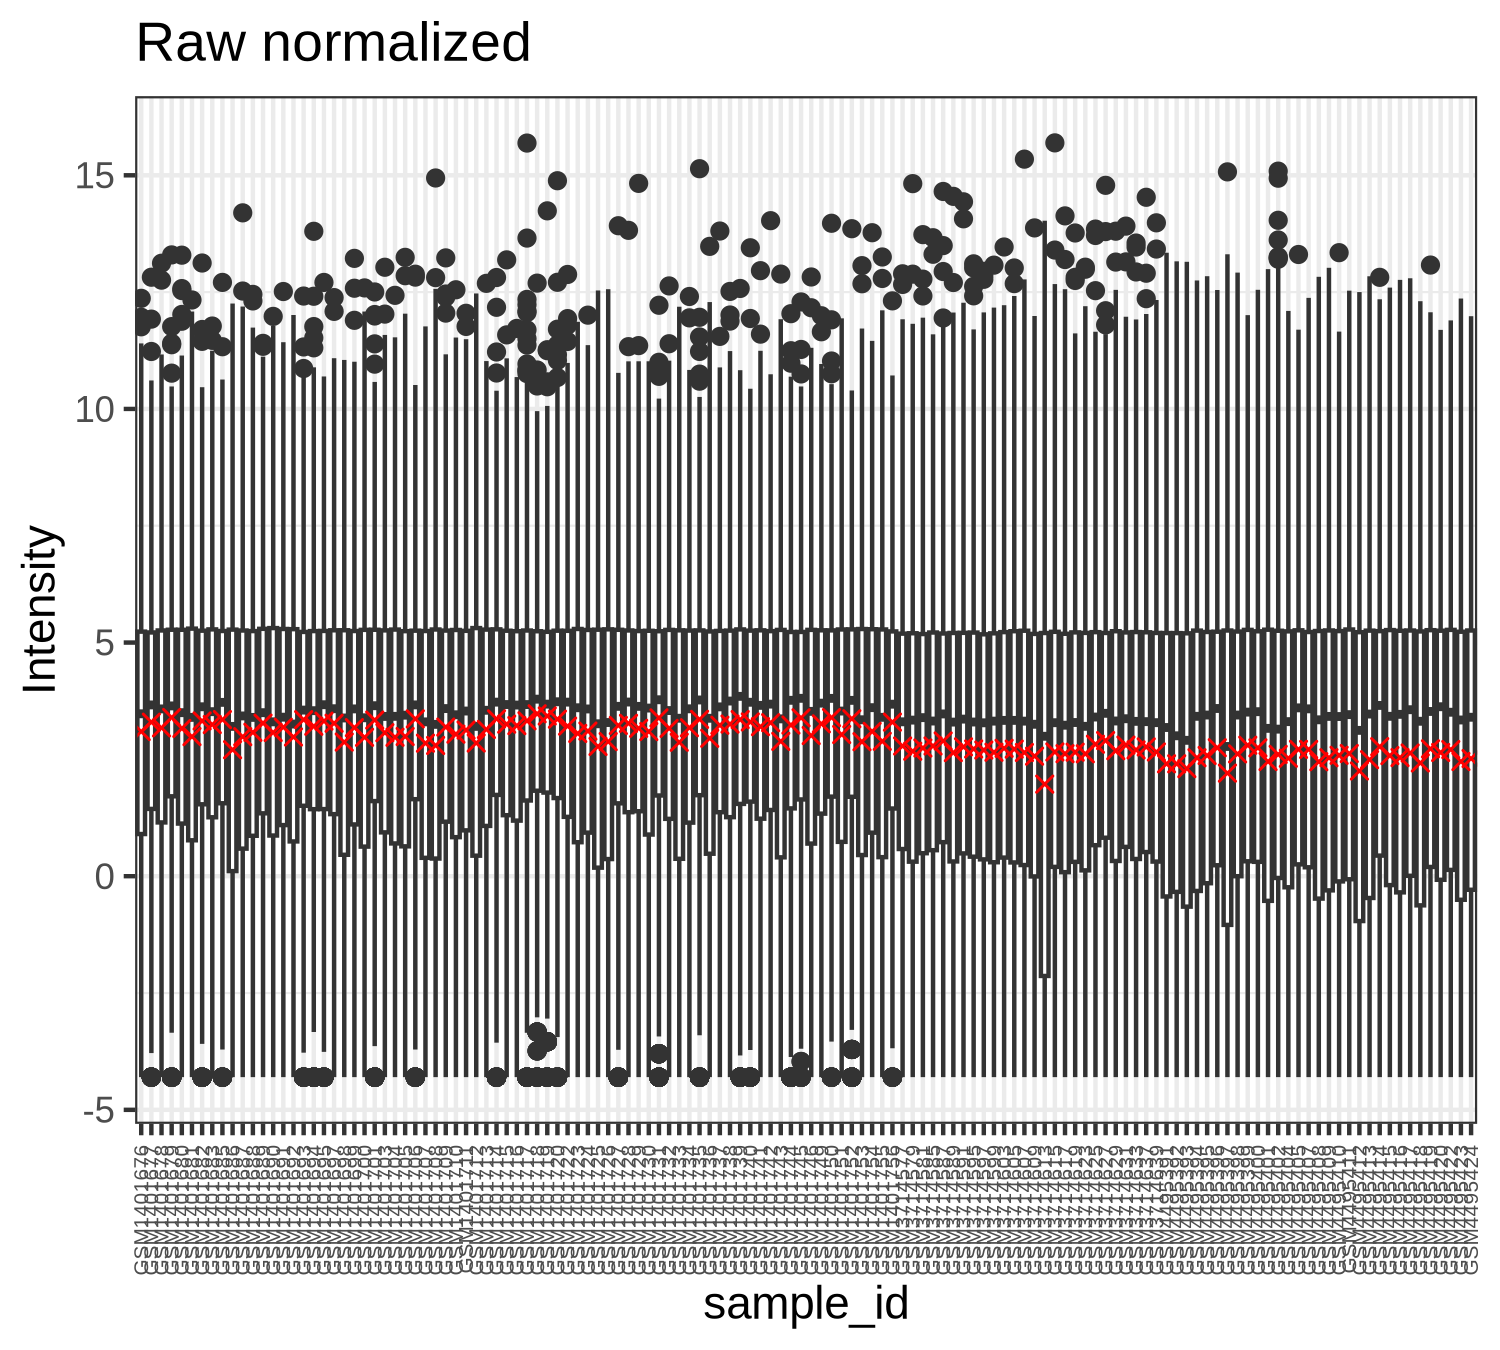

In [ ]:
boxplot_pg(as.data.frame(raw_exprs_normalized[sample(nrow(raw_exprs_normalized), 5000),]), "Raw normalized", "")

### after

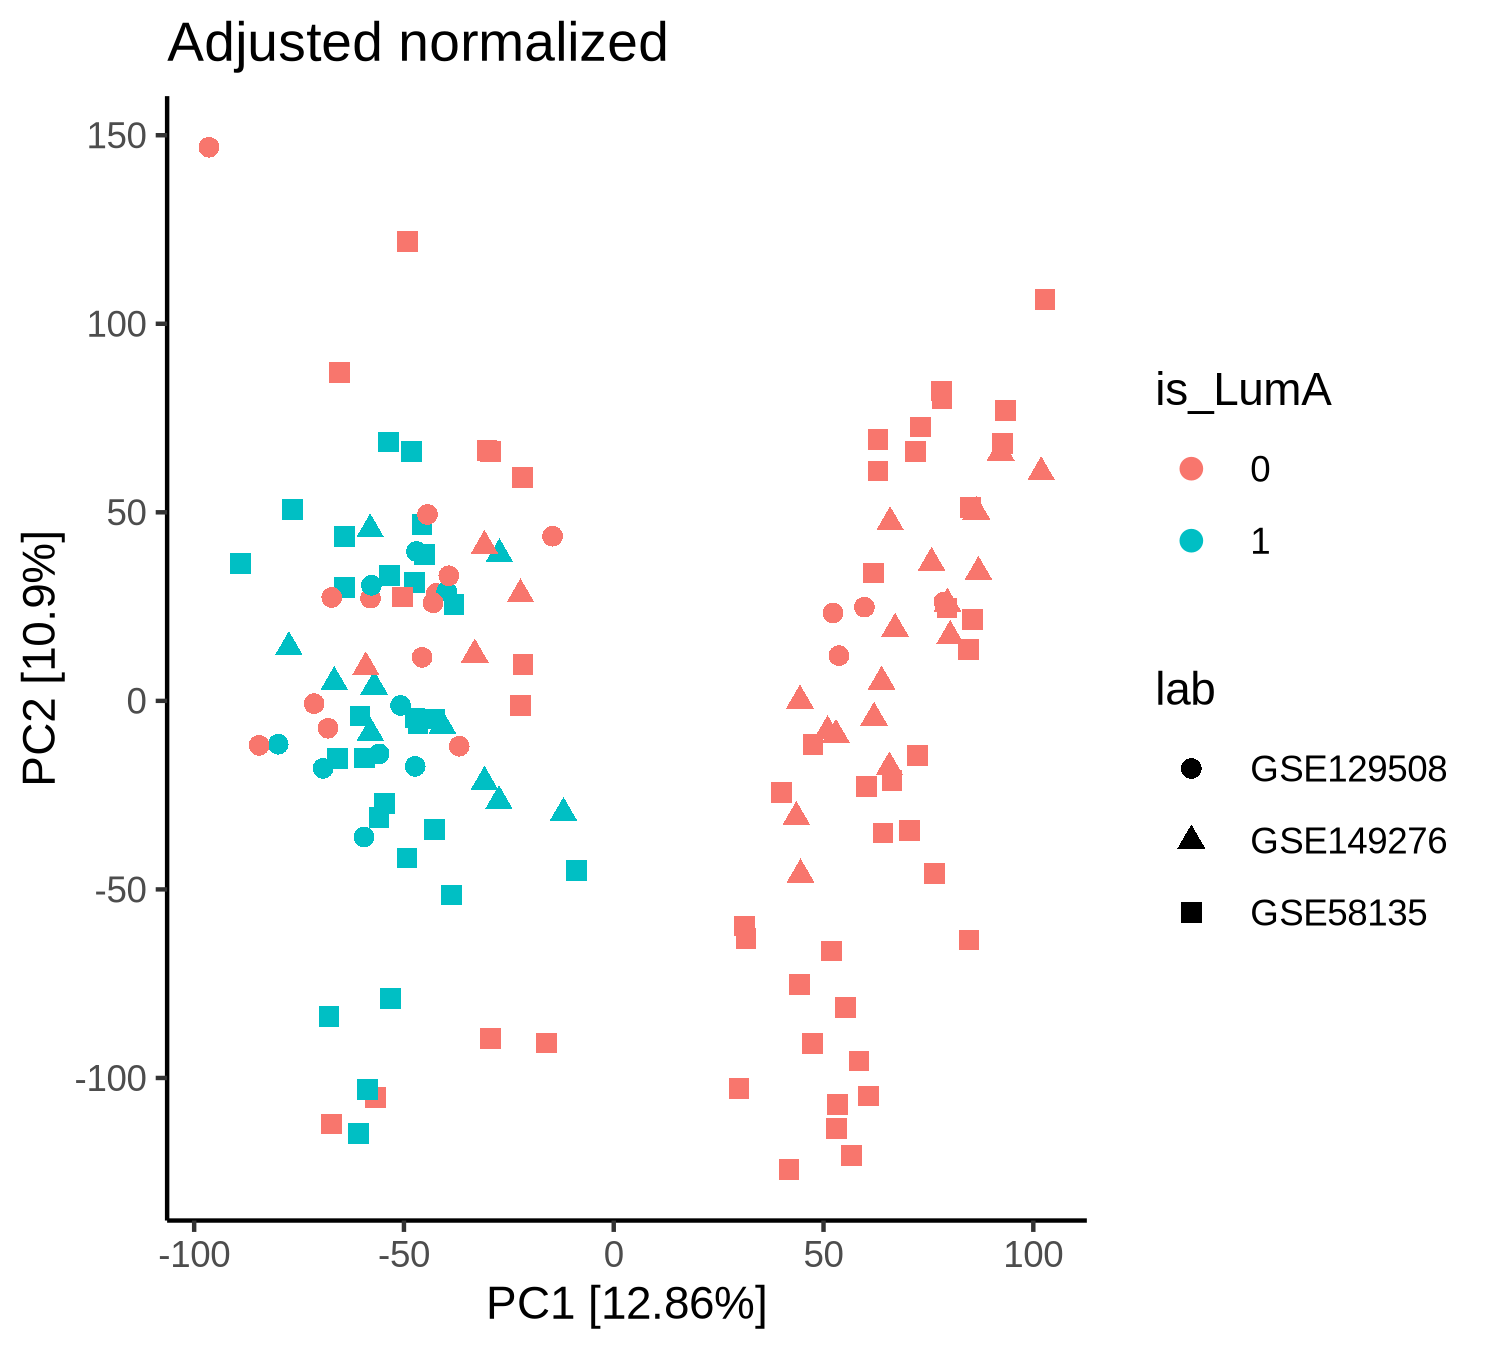

In [ ]:
# raw normalized
options(repr.plot.width =  5, repr.plot.height = 4.5, repr.plot.res = 300)
pca_plot(adjusted_exprs_normalized, meta_plots, "Adjusted normalized", "")

# Second type of correction - from scratch

In [13]:
head(data_matrix, 3)
head(raw_exprs_normalized, 3)
head(meta_info, 3)
head(meta_plots, 3)

,GSM3714577,GSM3714579,GSM3714581,GSM3714585,GSM3714587,GSM3714589,GSM3714591,GSM3714595,GSM3714597,GSM3714599,⋯,GSM1401714,GSM1401725,GSM1401692,GSM1401689,GSM1401752,GSM1401719,GSM1401736,GSM1401744,GSM1401681,GSM1401723
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
A1BG,363,732,650,379,912,98,376,88,506,184,⋯,1914,425,1051,1034,2422,1147,634,2498,1179,760
A1CF,5,16,0,7,15,0,3,4,2,10,⋯,110,9,33,38,205,76,26,83,26,41
A2M,19059,16821,15554,14844,31897,10656,15895,32102,26985,20846,⋯,5048,11582,16842,19400,1912,4247,48515,18468,2978,256904


,GSM3714577,GSM3714579,GSM3714581,GSM3714585,GSM3714587,GSM3714589,GSM3714591,GSM3714595,GSM3714597,GSM3714599,⋯,GSM1401714,GSM1401725,GSM1401692,GSM1401689,GSM1401752,GSM1401719,GSM1401736,GSM1401744,GSM1401681,GSM1401723
A1BG,3.427972,4.6818628,4.394393,4.032185,4.661398,1.935841,3.785306,1.127351,3.705522,2.864899,⋯,6.021296,2.689867,4.4189874,4.475718,5.965890,5.334068,3.044363,5.466796,4.7461815,3.4646067
A1CF,-2.334306,-0.7115367,-4.300637,-1.506405,-1.101217,-4.300637,-2.640736,-2.758910,-3.291839,-1.171689,⋯,1.918648,-2.424217,-0.4722795,-0.206615,2.415998,1.443697,-1.369657,0.602655,-0.6405645,-0.6358548
A2M,9.135644,9.2014082,8.971756,9.319356,9.786829,8.681425,9.181809,9.604483,9.436882,9.678825,⋯,7.419717,7.447174,8.4180041,8.702348,5.625086,7.221321,9.293383,8.351546,6.0813127,11.8589939


,Lum,Basal,is_LumA,lab
,<int>,<int>,<fct>,<fct>
GSM3714577,1,0,1,GSE129508
GSM3714579,1,0,0,GSE129508
GSM3714581,1,0,0,GSE129508


,sample_id,Lum,Basal,is_LumA,lab
,<chr>,<int>,<int>,<fct>,<fct>
GSM3714577,GSM3714577,1,0,1,GSE129508
GSM3714579,GSM3714579,1,0,0,GSE129508
GSM3714581,GSM3714581,1,0,0,GSE129508


In [14]:
meta_info <- meta_info %>% mutate(condition = as.factor(ifelse(is_LumA == 1, "LumA", 
                                        ifelse(Basal == 1, "Basal", "LumB"))))

In [15]:
batch <- as.numeric(meta_info$lab) - 1
covariate <- as.numeric(meta_info$condition) - 1

corrected_data <- ComBat_seq(data_matrix, batch=batch, group=group, full_mod=TRUE)
head(adjusted_counts, 3)

In [ ]:
# normalization
corrected_exprs <- DGEList(corrected_data)

keep_exprs <- filterByExpr(corrected_exprs, group=meta_info$condition)

cat(paste0("Genes passed filterByExprs: ",length(keep_exprs[keep_exprs])))
corrected_exprs_filtered <- corrected_exprs[keep_exprs,, keep.lib.sizes=FALSE]

corrected_exprs <- calcNormFactors(corrected_exprs_filtered, method = "upperquartile") # TMM

corrected_data_normalized <- cpm(corrected_exprs, log=TRUE)
head(corrected_data_normalized, 3)

Genes passed filterByExprs: 20224

,GSM1401701,GSM1401724,GSM1401678,GSM1401710,GSM1401743,GSM1401726,GSM1401742,GSM1401755,GSM1401730,GSM1401708,⋯,GSM4495414,GSM4495415,GSM4495416,GSM4495417,GSM4495418,GSM4495419,GSM4495420,GSM4495422,GSM4495423,GSM4495424
A1BG,5.5761677,3.087575,4.5886556,4.251992,2.174759,2.237161,3.6554311,3.888238,3.182499,4.6218455,⋯,4.274082,3.8020332,4.248059,3.810585,4.348388,5.029339,5.232856,5.705825,4.533812,3.446061
A1CF,0.6732425,-1.783893,-0.3138786,-1.164179,-1.698365,-2.128859,-0.8292839,-1.683448,-1.298304,-0.8387494,⋯,-1.054852,0.5973171,-1.667070,-1.175780,-1.411308,-1.601908,-1.888280,-1.291994,-1.656688,-2.634421
A2M,7.2448323,11.505737,8.6943791,9.766885,8.680408,8.162300,10.4792773,7.341642,7.978465,7.8310215,⋯,9.791678,8.0738879,8.763844,9.889421,8.335057,8.343988,7.838088,9.214975,11.662465,8.791118


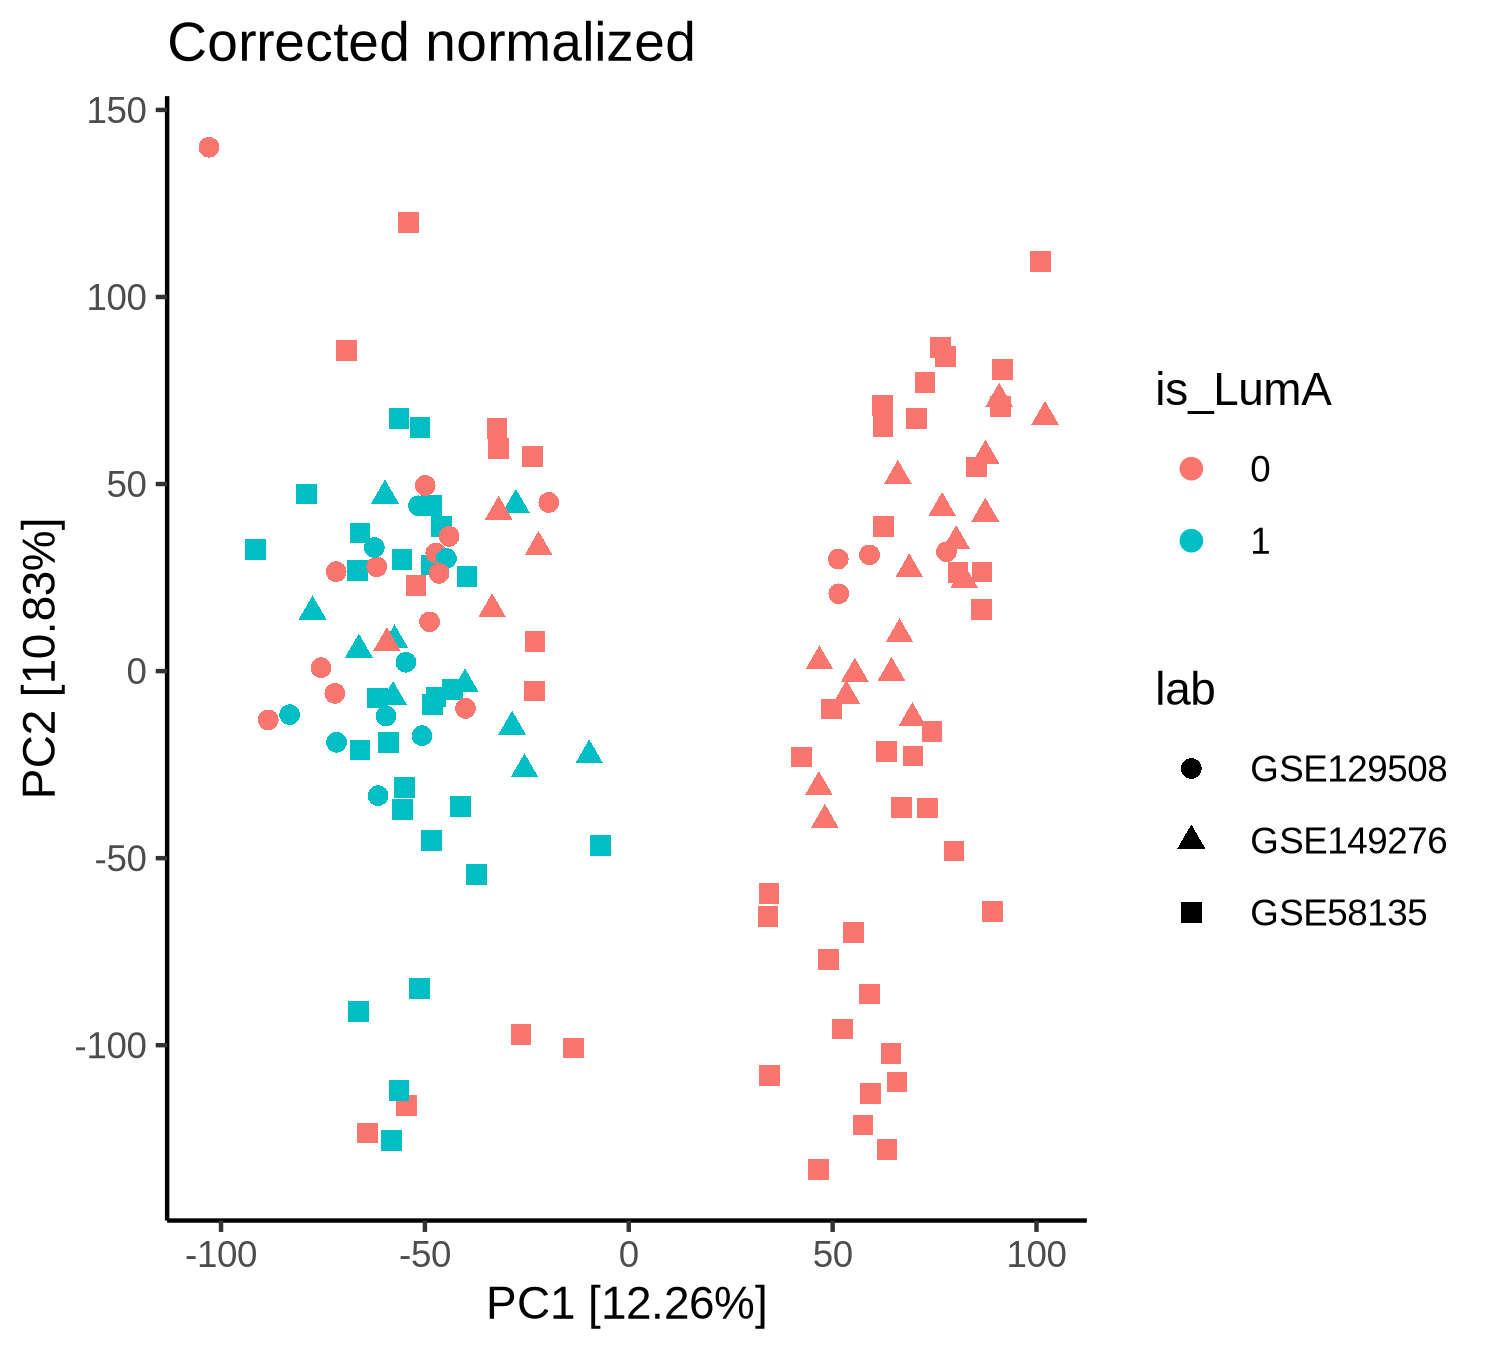

In [ ]:
# raw normalized
options(repr.plot.width =  5, repr.plot.height = 4.5, repr.plot.res = 300)
pca_plot(corrected_data_normalized, meta_plots, "Corrected normalized", "")

In [16]:
pca_plot <- function(df, batch_info, title, path) {
  pca <- prcomp(t(na.omit(df)))
  # Plot PCA
  pca_df <-
    pca$x %>%
    as.data.frame() %>%
    rownames_to_column("sample_id") %>% 
    left_join(batch_info,  by = "sample_id") 
  # add % of explained variance
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))
  # Add the label for the specific point
  pca_plot <- pca_df %>%
    ggplot(aes(PC1, PC2)) +
    geom_point(aes(col=lab, shape=Lum), size=2) +
    theme_classic() +
    labs(title = title,
         x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
         y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]"))

  if(path != "") {ggsave(path, pca_plot)}
  return(pca_plot)
}

In [ ]:
meta_plots <- meta_plots %>% mutate(condition = as.factor(ifelse(is_LumA == 1, "LumA", 
                                        ifelse(Basal == 1, "Basal", "LumB")))) %>%
                                        mutate(Lum = as.factor(Lum))

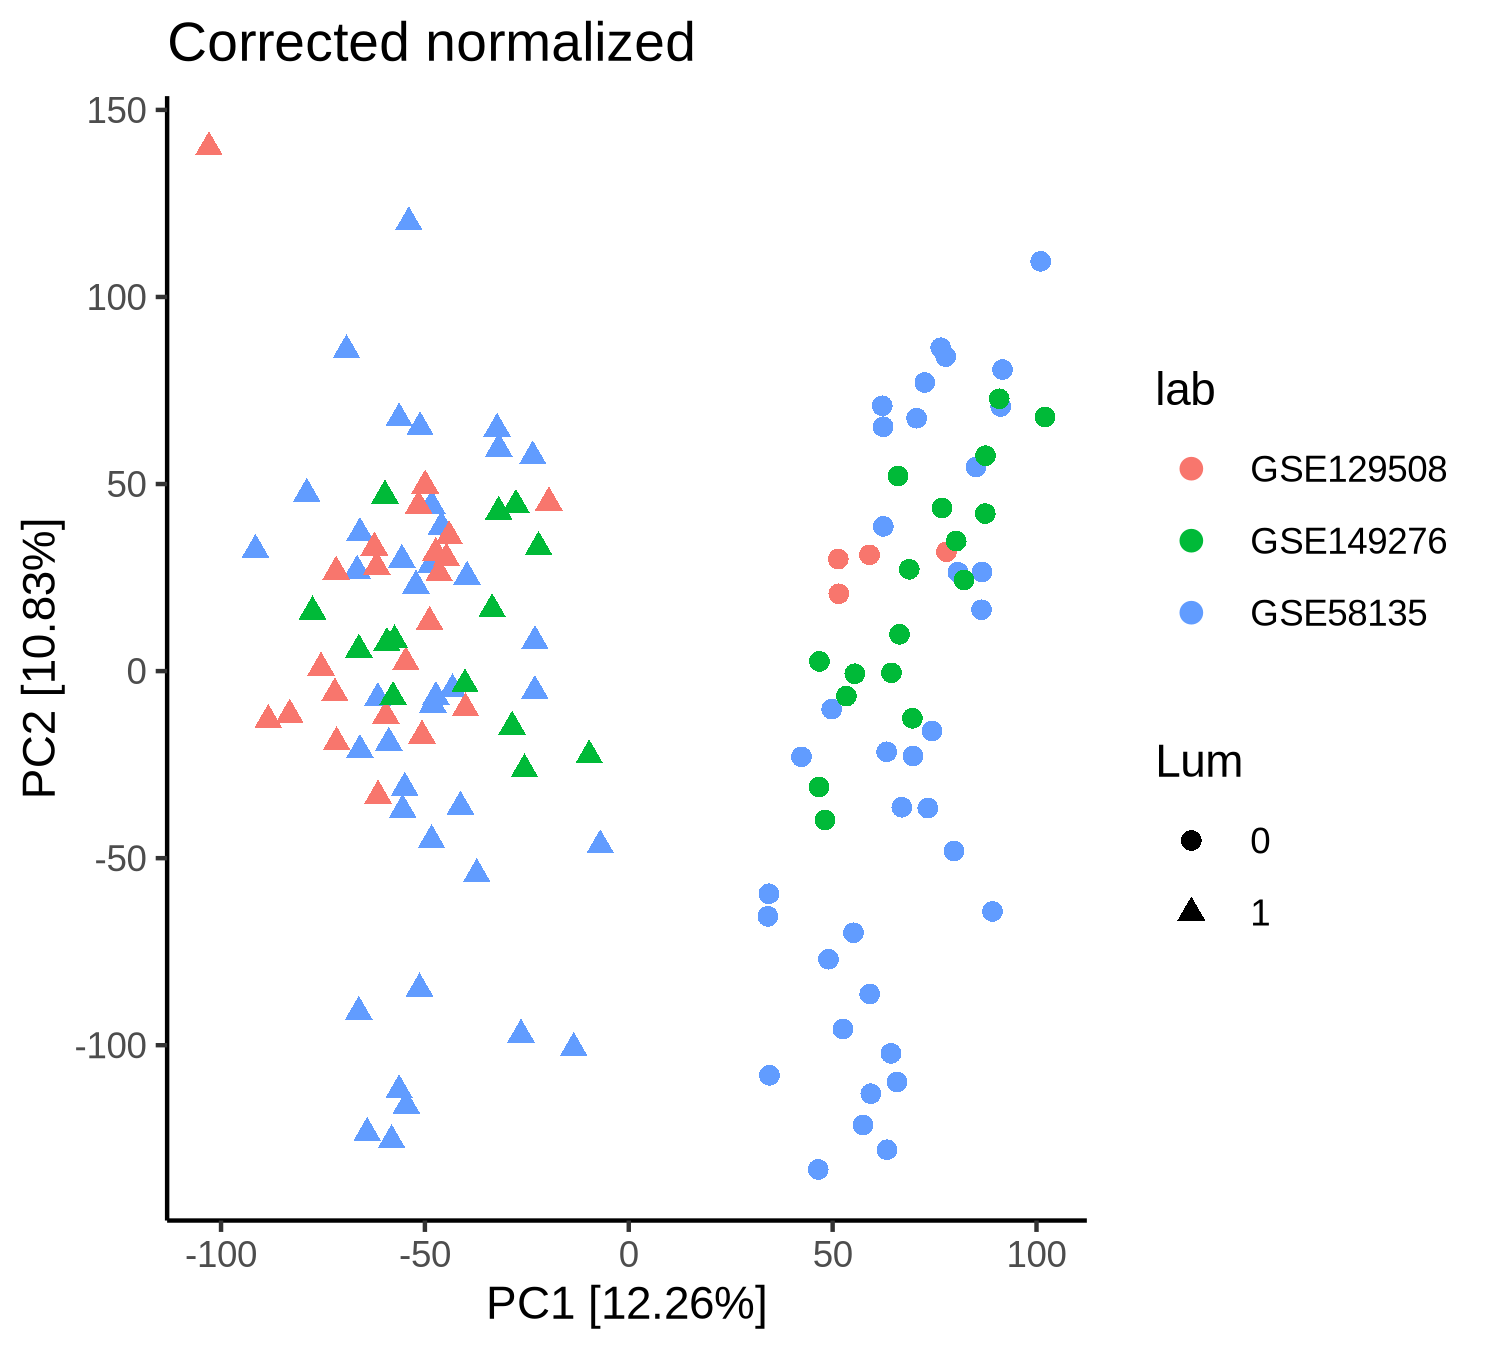

In [ ]:
# raw normalized
options(repr.plot.width =  5, repr.plot.height = 4.5, repr.plot.res = 300)
pca_plot(corrected_data_normalized, meta_plots, "Corrected normalized", "")

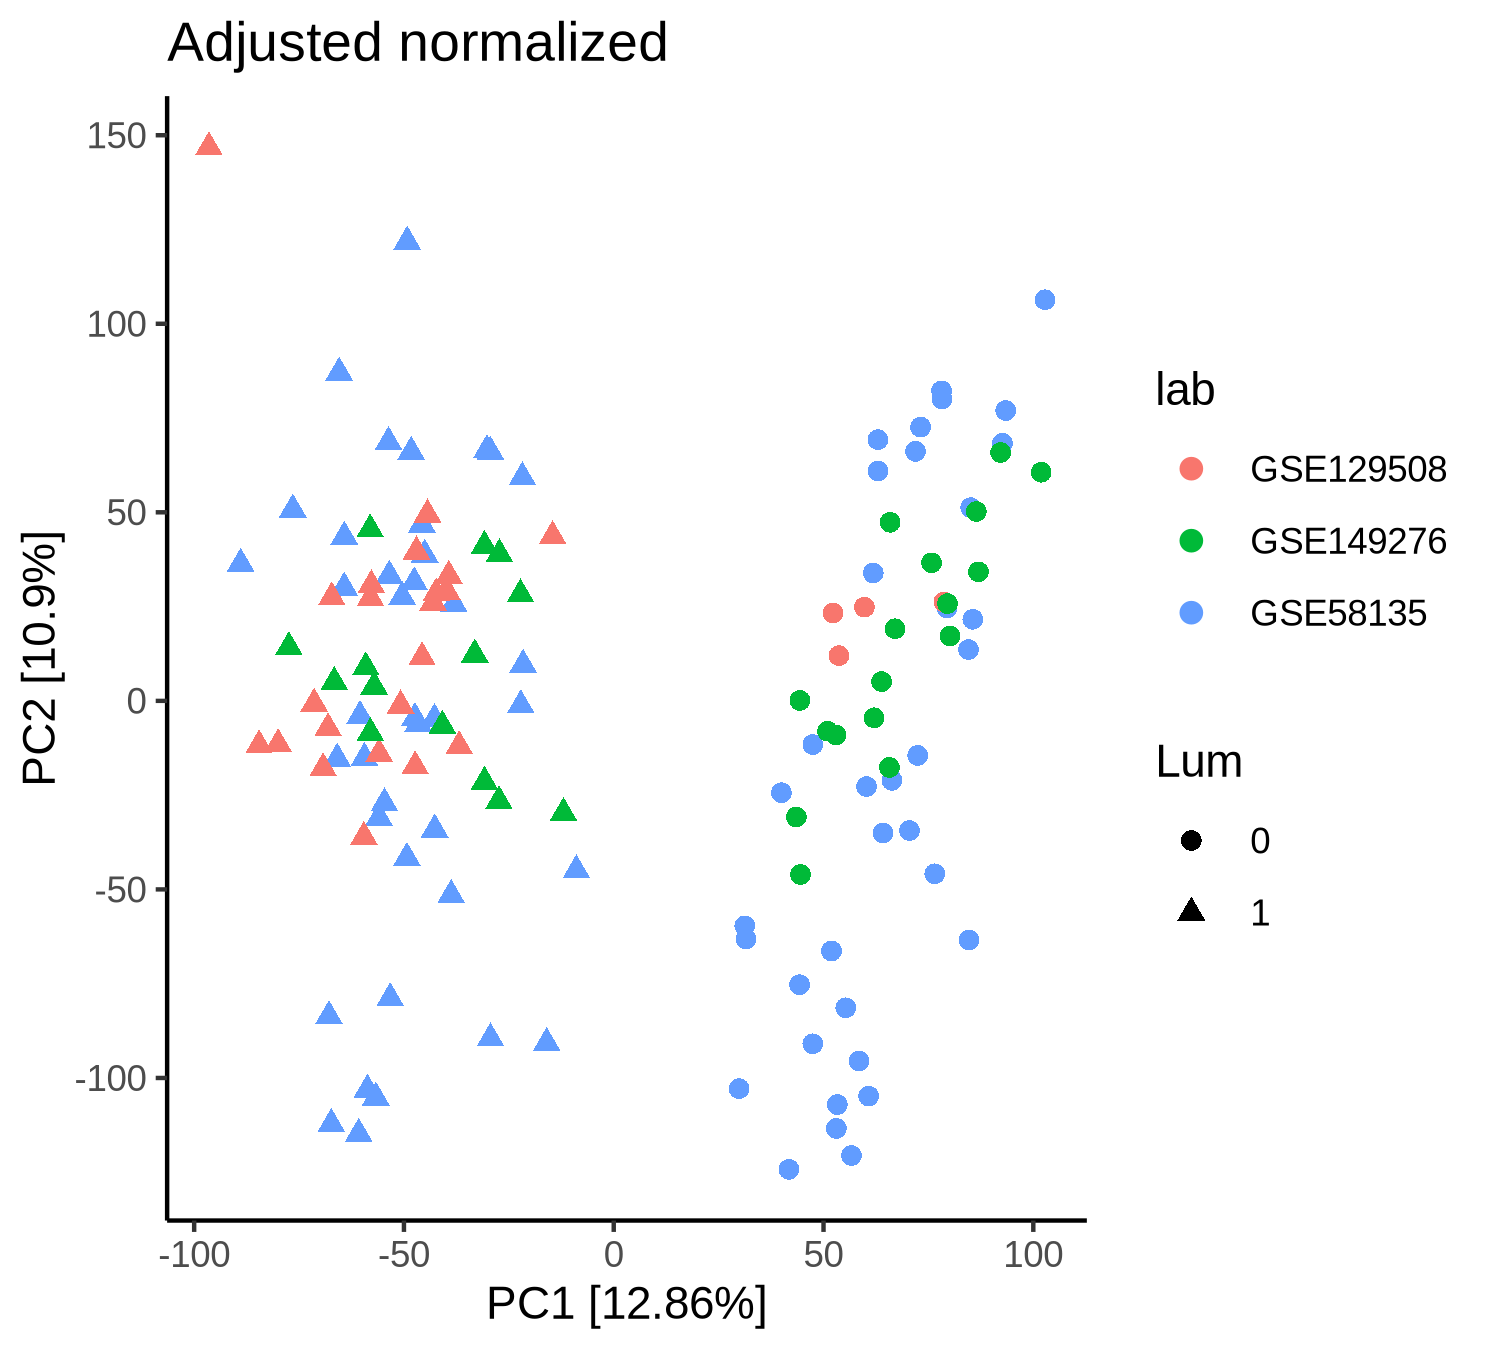

In [ ]:
# raw normalized
options(repr.plot.width =  5, repr.plot.height = 4.5, repr.plot.res = 300)
pca_plot(adjusted_exprs_normalized, meta_plots, "Adjusted normalized", "")

In [ ]:
pca_plot <- function(df, batch_info, title, path) {
  pca <- prcomp(t(na.omit(df)))
  # Plot PCA
  pca_df <-
    pca$x %>%
    as.data.frame() %>%
    rownames_to_column("sample_id") %>% 
    left_join(batch_info,  by = "sample_id") 
  # add % of explained variance
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))
  # Add the label for the specific point
  pca_plot <- pca_df %>%
    ggplot(aes(PC1, PC2)) +
    geom_point(aes(col=Lum, shape=lab), size=2) +
    theme_classic() +
    labs(title = title,
         x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
         y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]"))

  if(path != "") {ggsave(path, pca_plot)}
  return(pca_plot)
}

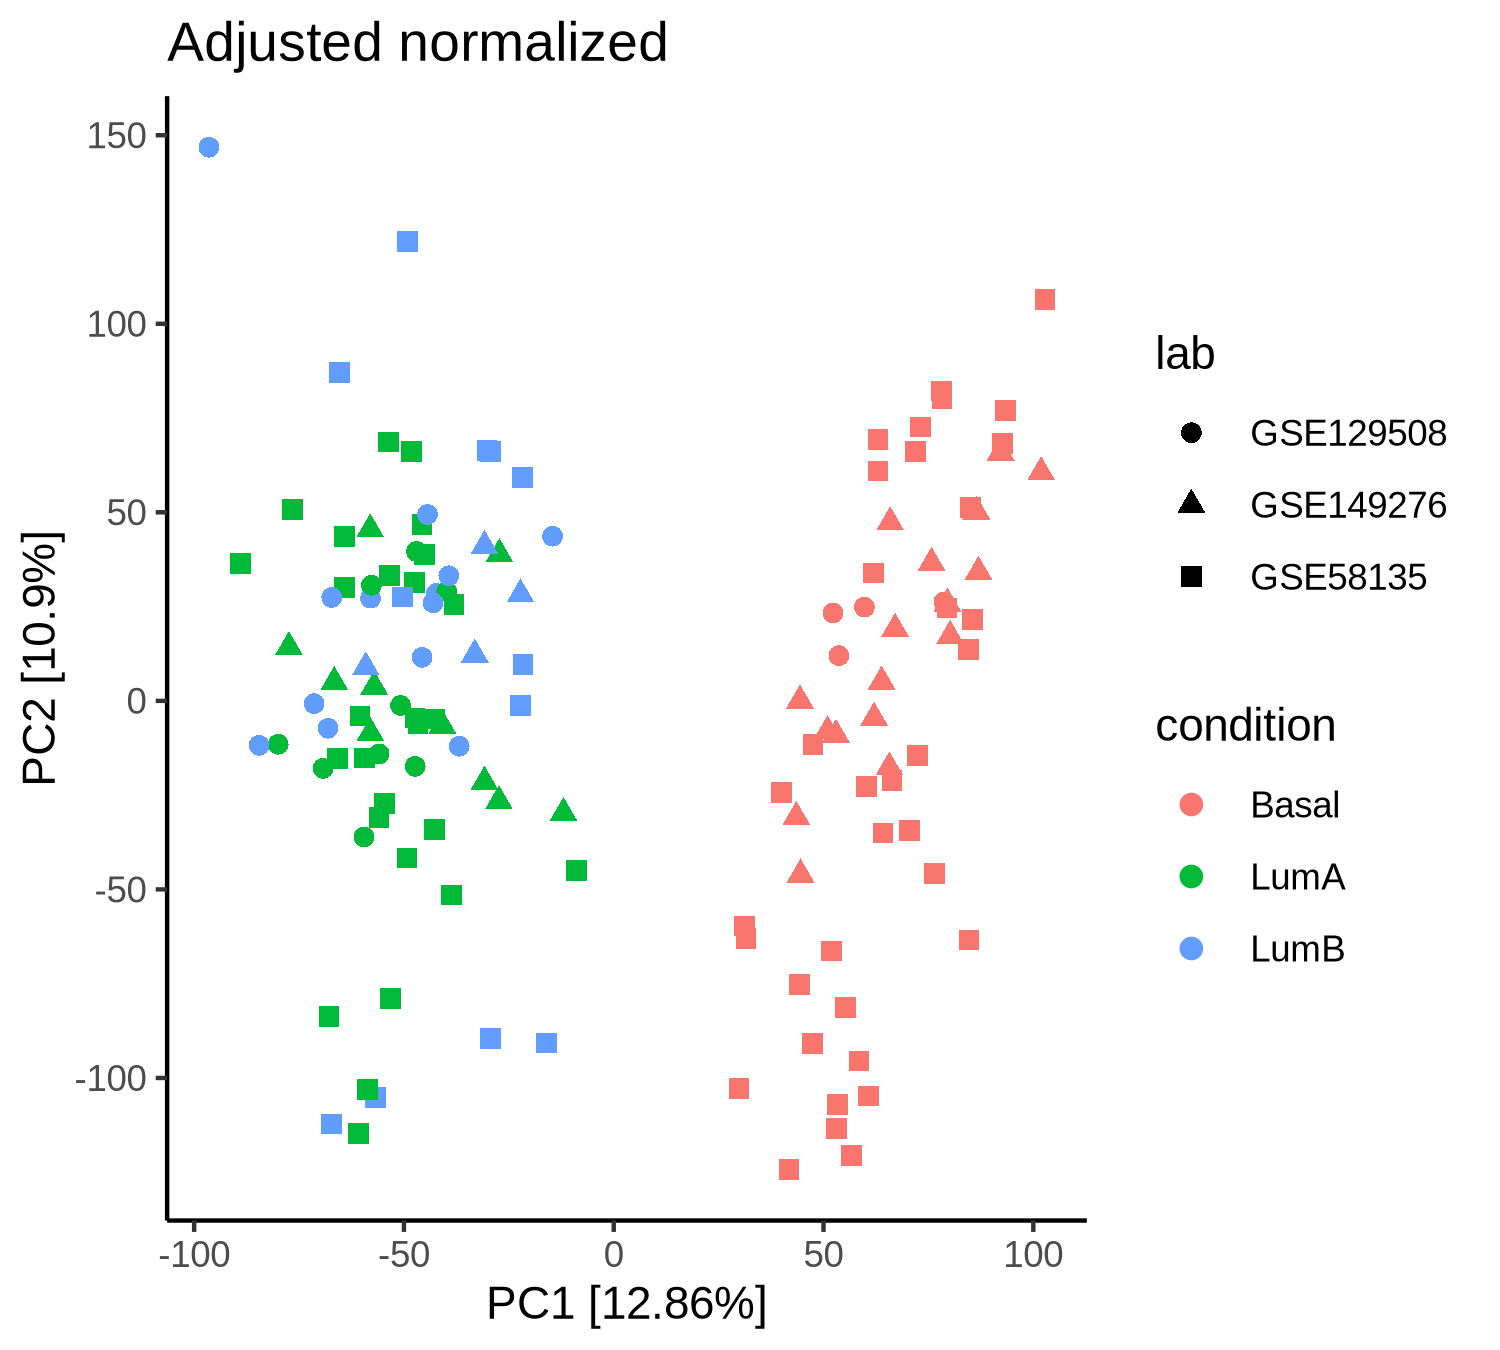

In [ ]:
# raw normalized
options(repr.plot.width =  5, repr.plot.height = 4.5, repr.plot.res = 300)
pca_plot(adjusted_exprs_normalized, meta_plots, "Adjusted normalized", "")

# ComBat

In [ ]:
mod_covariates <- model.matrix(~ Lum, data=meta_info)
batch <- as.numeric(meta_info$lab) - 1
# Run ComBat
batch_corrected_norm_data <- ComBat(raw_exprs_normalized, batch=batch, mod=mod_covariates)

Found3batches

Adjusting for1covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




In [ ]:
meta_info %>% group_by(as.numeric(lab)) %>% summarise(n = n())

as.numeric(lab),n
<dbl>,<int>
1,26
2,31
3,75


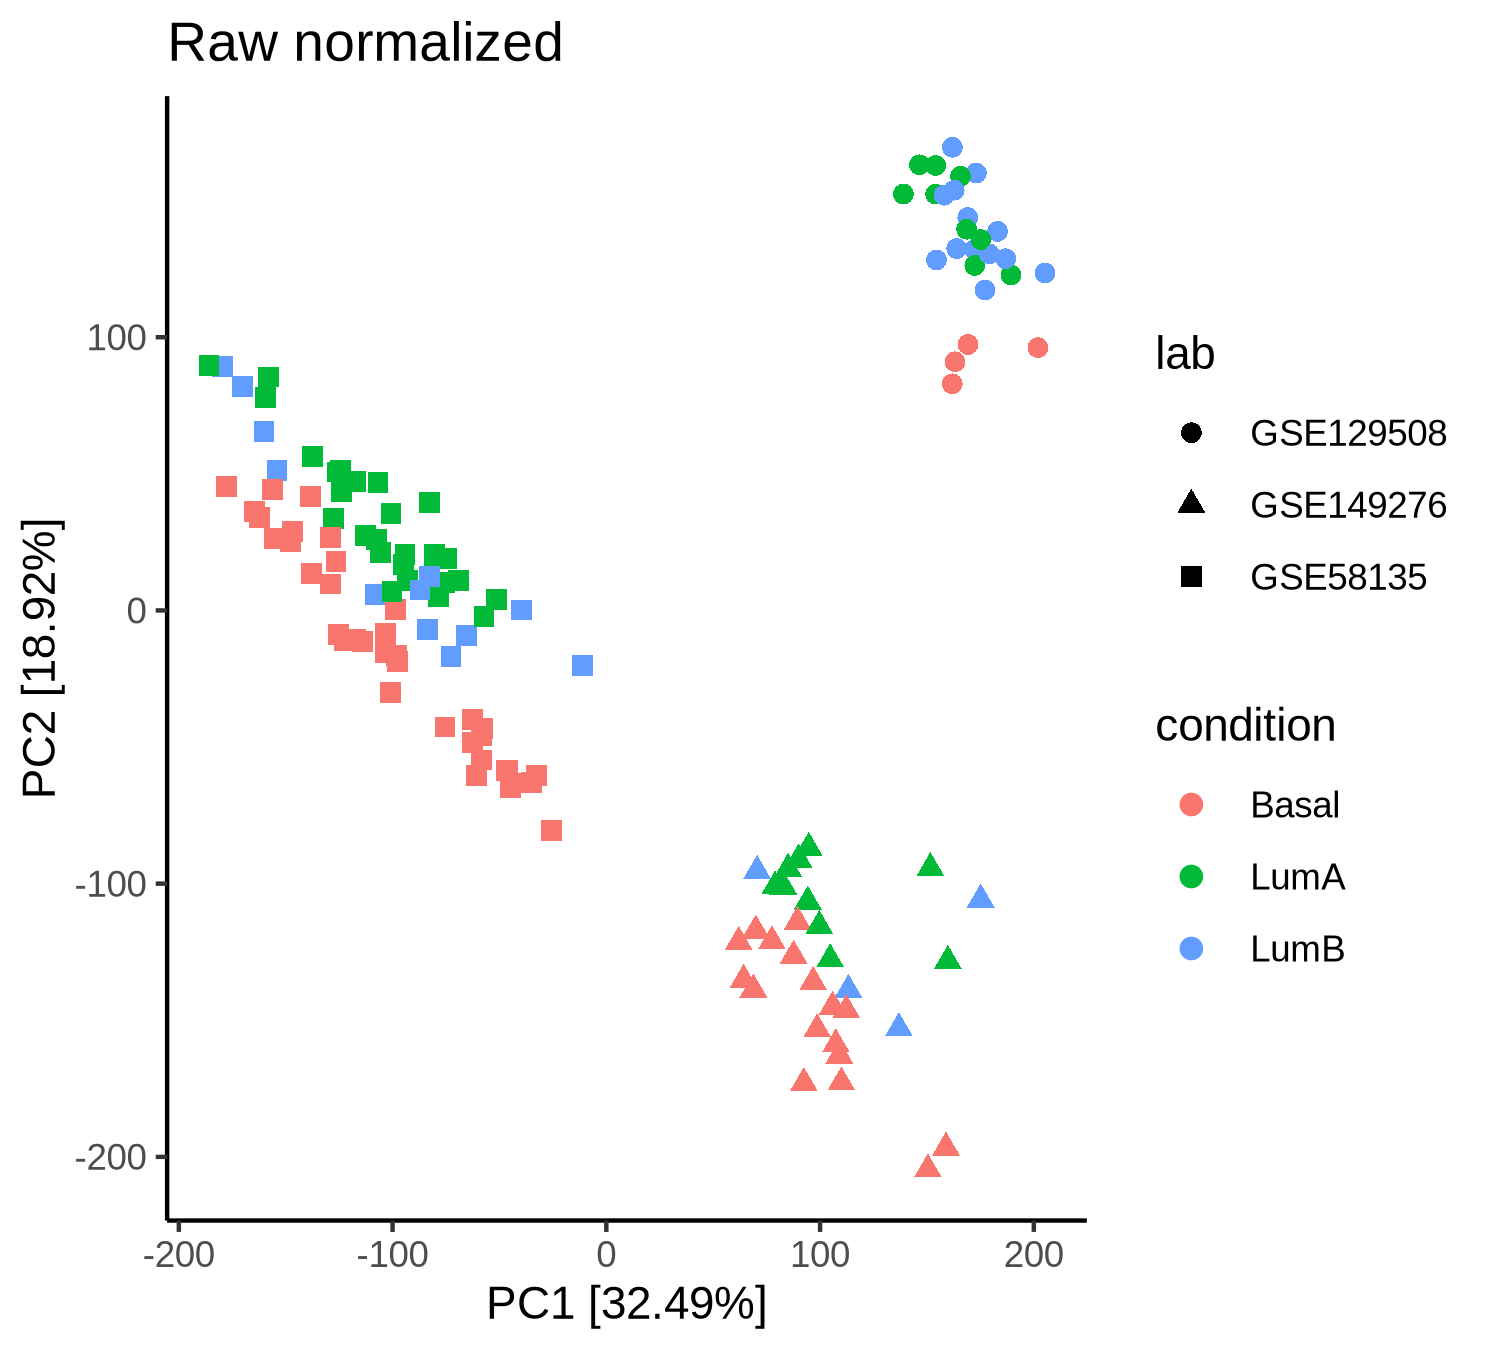

In [ ]:
# raw normalized
options(repr.plot.width =  5, repr.plot.height = 4.5, repr.plot.res = 300)
pca_plot(raw_exprs_normalized, meta_plots, "Raw normalized", "")

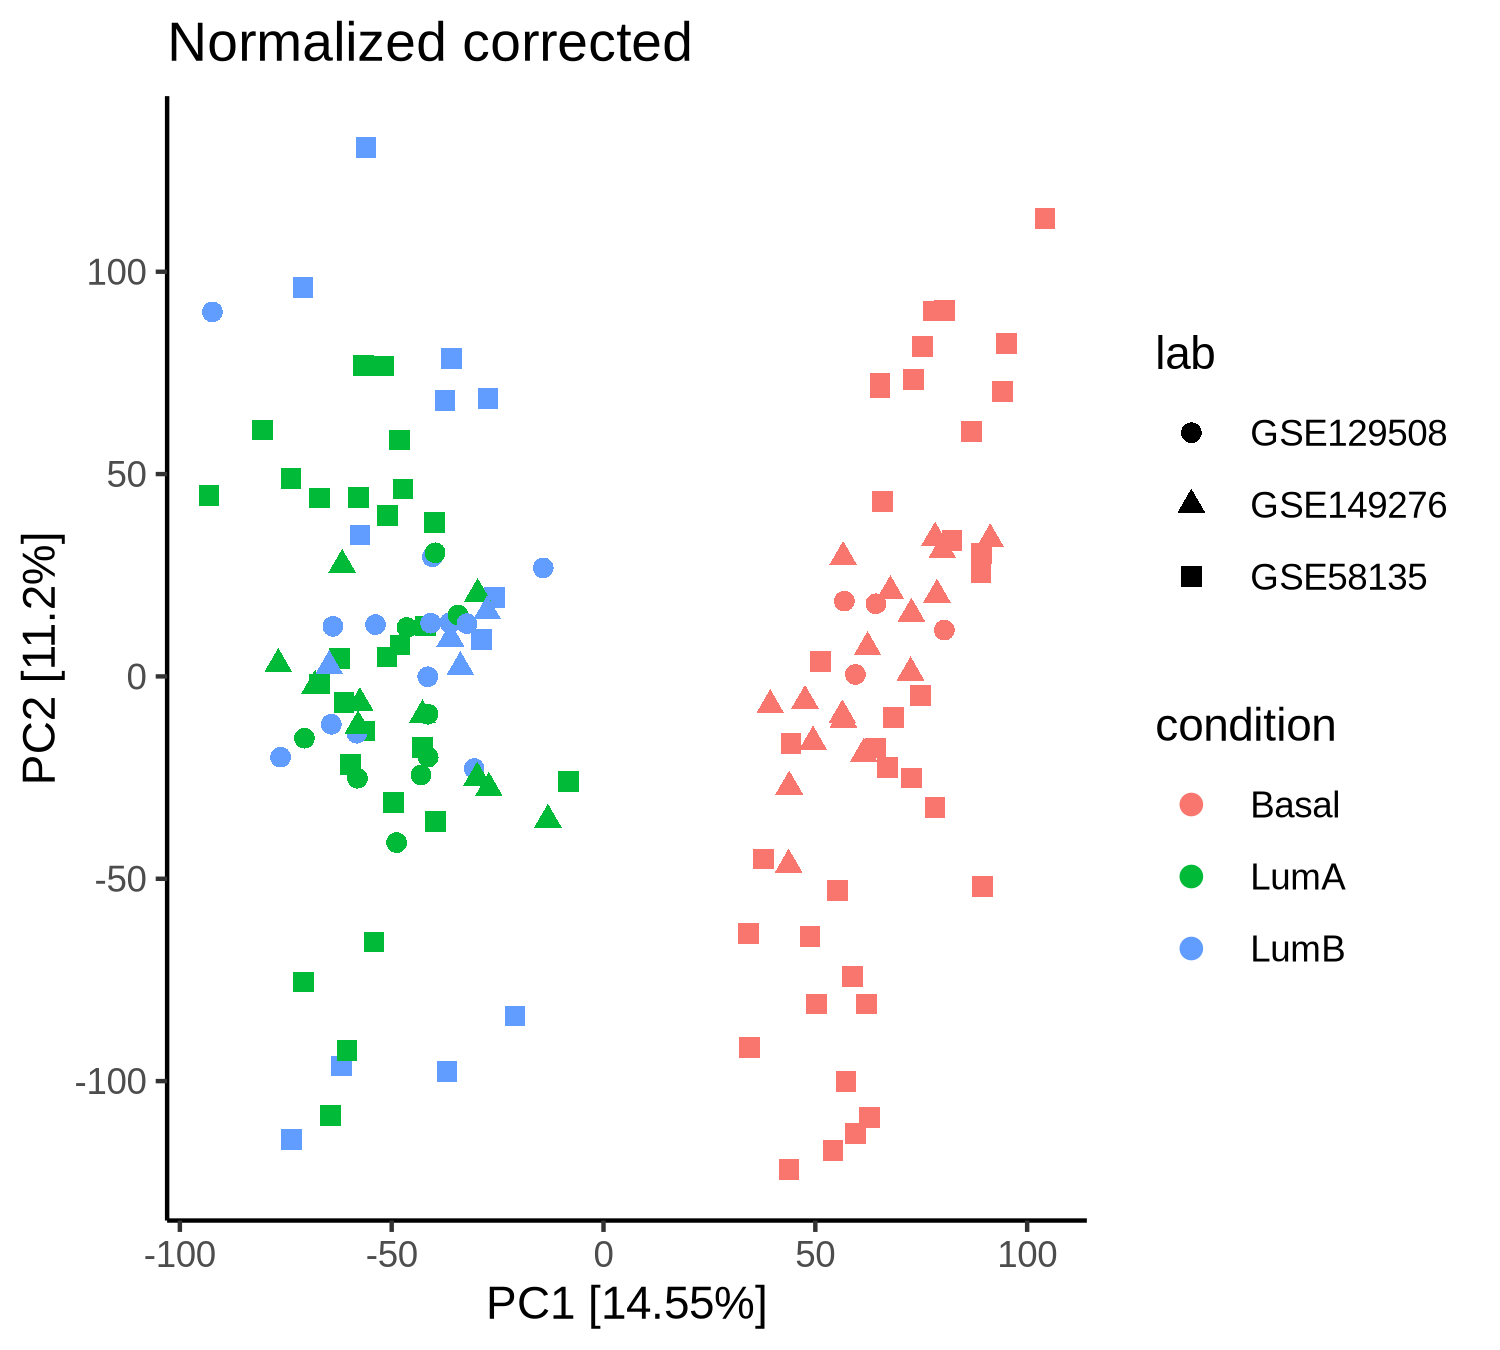

In [ ]:
# raw normalized
options(repr.plot.width =  5, repr.plot.height = 4.5, repr.plot.res = 300)
pca_plot(batch_corrected_norm_data, meta_plots, "Normalized corrected", "")

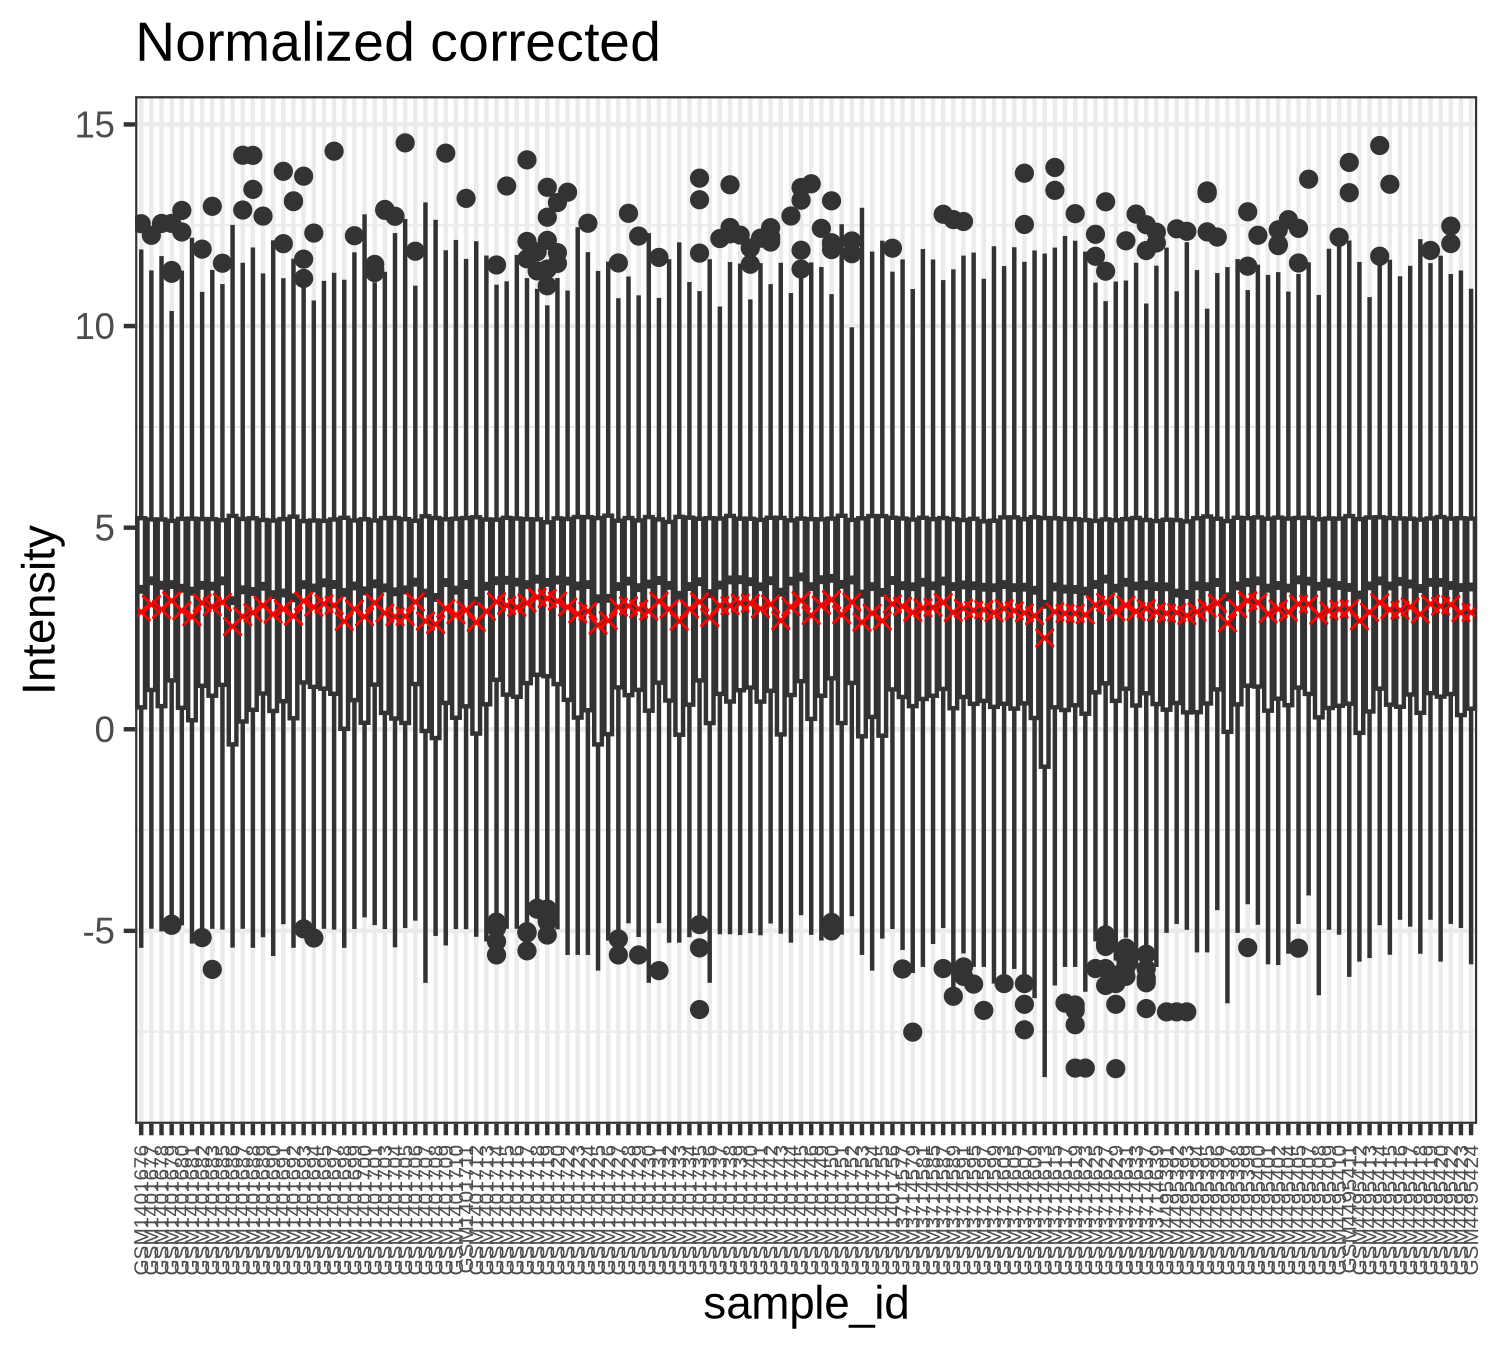

In [ ]:
boxplot_pg(as.data.frame(batch_corrected_norm_data[sample(nrow(batch_corrected_norm_data), 5000),]), "Normalized corrected", "")

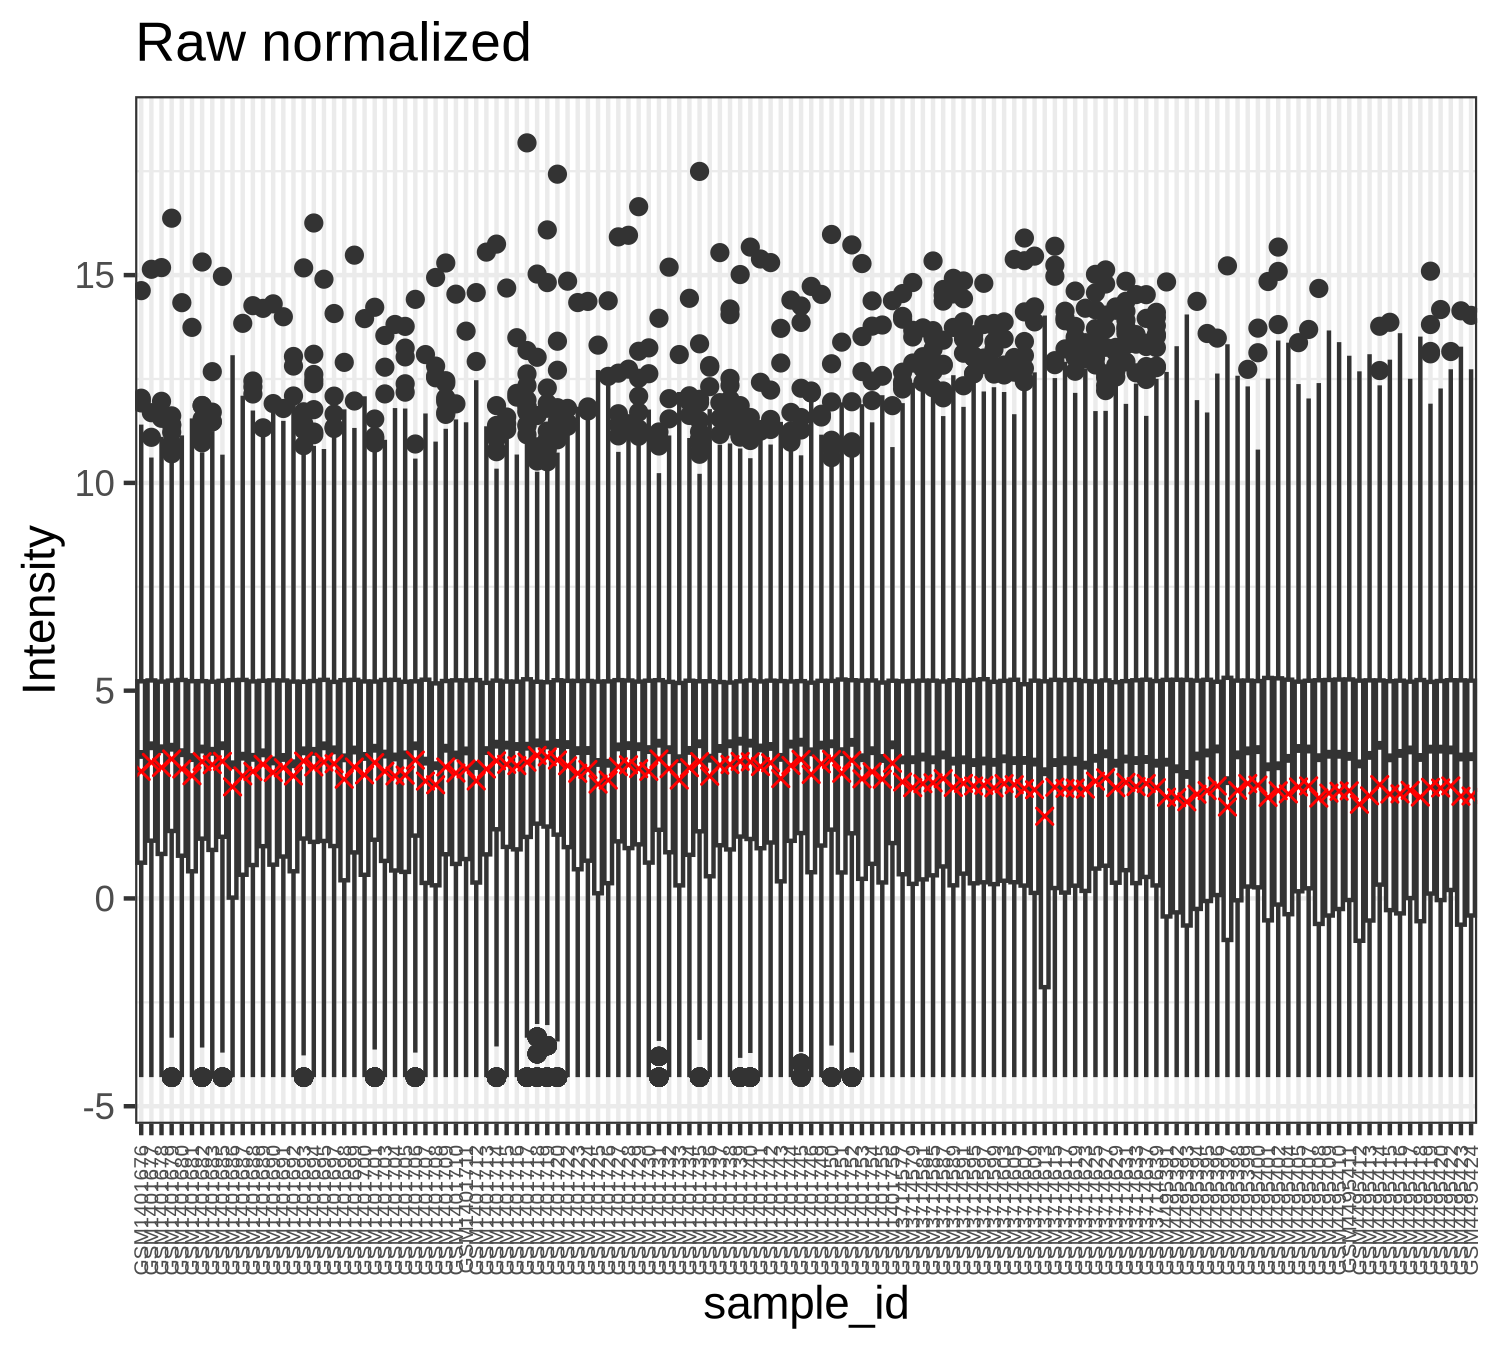

In [ ]:
boxplot_pg(as.data.frame(raw_exprs_normalized[sample(nrow(raw_exprs_normalized), 5000),]), "Raw normalized", "")

## not notm inpts

In [ ]:
# lab_A_intensities = read.csv("/home/yuliya/repos/cosybio/removeBatch/test_data/counts/raw/GSE58135.counts.tsv", sep='\t', row.names=1)
# lab_C_intensities = read.csv("/home/yuliya/repos/cosybio/removeBatch/test_data/counts/raw/GSE129508.counts.tsv", sep='\t', row.names=1)
# lab_D_intensities = read.csv("/home/yuliya/repos/cosybio/removeBatch/test_data/counts/raw//GSE149276.counts.tsv", sep='\t', row.names=1)

# pg_matrix <- cbind(lab_A_intensities, lab_C_intensities, lab_D_intensities)

# batch_info_2 <- data.frame(file = c(colnames(pg_matrix)))
# batch_info_2$condition <- c(
#   rep('A', length(colnames(lab_A_intensities))),
#   rep('B', length(colnames(lab_C_intensities))),
#   rep('C', length(colnames(lab_D_intensities)))
# )

In [ ]:
mod_covariates <- model.matrix(~ Lum, data=meta_info)
batch <- as.numeric(meta_info$lab) - 1
# Run ComBat
batch_corrected_second_data <- ComBat(data_matrix, batch=batch, mod=mod_covariates)

Found 6394 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found3batches

Adjusting for1covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




In [ ]:
meta_plots <- meta_plots %>% mutate(Lum = as.factor(Lum))

Warning message in na.omit(df):
“NaNs produced”


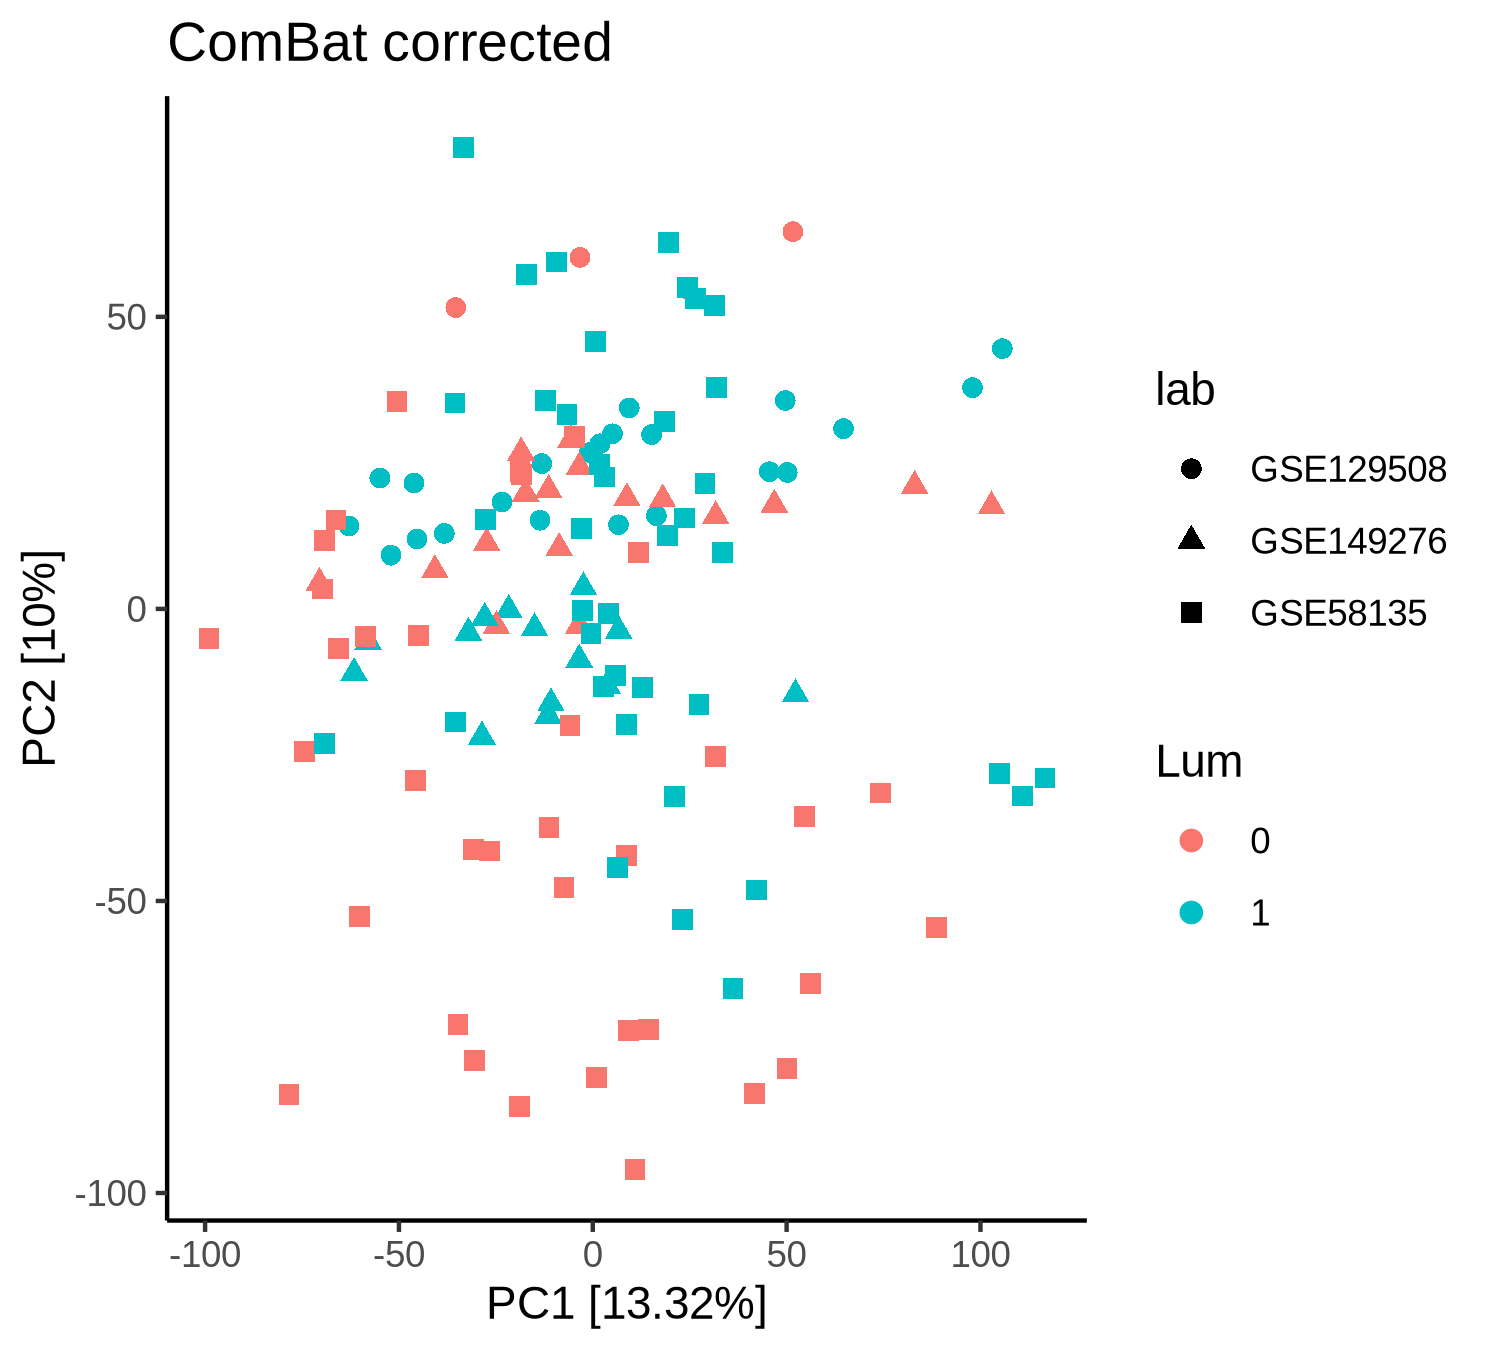

In [ ]:
# raw normalized
options(repr.plot.width =  5, repr.plot.height = 4.5, repr.plot.res = 300)
pca_plot(log2(batch_corrected_second_data + 1), meta_plots, "ComBat corrected", "")

In [24]:
batch_corrected_second_data_zeros <- data_matrix %>% mutate_all(~pmax(., 0))

In [33]:
pca <- prcomp(t(log2(batch_corrected_second_data_zeros + 1)))
  # Plot PCA
pca_df <-
  pca$x %>%
  as.data.frame() %>%
  rownames_to_column("sample_id") %>% 
  left_join(meta_plots,  by = "sample_id") 
  
# add % of explained variance
var_expl <- pca$sdev^2 / sum(pca$sdev^2)
names(var_expl) <- paste0("PC", 1:length(var_expl))


# Add the label for the specific point
pca_plot <- pca_df %>%
ggplot(aes(PC1, PC2)) +
geom_point(aes(col=Lum, shape=lab), size=2) +
theme_classic() +
labs(title = title,
        x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
        y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]"))


In [35]:
var_expl

PC1          PC2          PC3          PC4          PC5          PC6 
3.426506e-01 1.459827e-01 6.416259e-02 5.079357e-02 2.681431e-02 1.671157e-02 
         PC7          PC8          PC9         PC10         PC11         PC12 
1.431460e-02 1.033756e-02 1.017676e-02 8.472377e-03 7.915150e-03 7.238862e-03 
        PC13         PC14         PC15         PC16         PC17         PC18 
6.943729e-03 6.490211e-03 6.320016e-03 5.835820e-03 5.684251e-03 5.278302e-03 
        PC19         PC20         PC21         PC22         PC23         PC24 
5.151657e-03 4.960110e-03 4.721369e-03 4.440383e-03 4.353100e-03 4.166266e-03 
        PC25         PC26         PC27         PC28         PC29         PC30 
4.103522e-03 3.900620e-03 3.847679e-03 3.738172e-03 3.693720e-03 3.624614e-03 
        PC31         PC32         PC33         PC34         PC35         PC36 
3.486836e-03 3.463377e-03 3.398426e-03 3.367060e-03 3.308132e-03 3.274155e-03 
        PC37         PC38         PC39         PC40         PC41         PC42 
3.167949e-03 3.114639e-03 3.045318e-03 3.008818e-03 2.985986e-03 2.918681e-03 
        PC43         PC44         PC45         PC46         PC47         PC48 
2.910983e-03 2.873202e-03 2.832857e-03 2.783311e-03 2.742664e-03 2.717184e-03 
        PC49         PC50         PC51         PC52         PC53         PC54 
2.699008e-03 2.660041e-03 2.648278e-03 2.615928e-03 2.567566e-03 2.549250e-03 
        PC55         PC56         PC57         PC58         PC59         PC60 
2.517359e-03 2.482774e-03 2.466812e-03 2.435263e-03 2.405540e-03 2.375094e-03 
        PC61         PC62         PC63         PC64         PC65         PC66 
2.353785e-03 2.326130e-03 2.320739e-03 2.297088e-03 2.254505e-03 2.240297e-03 
        PC67         PC68         PC69         PC70         PC71         PC72 
2.215270e-03 2.191657e-03 2.184976e-03 2.166745e-03 2.130933e-03 2.116833e-03 
        PC73         PC74         PC75         PC76         PC77         PC78 
2.095970e-03 2.080715e-03 2.078228e-03 2.057468e-03 2.005768e-03 1.995452e-03 
        PC79         PC80         PC81         PC82         PC83         PC84 
1.991123e-03 1.976368e-03 1.955423e-03 1.929070e-03 1.916693e-03 1.898988e-03 
        PC85         PC86         PC87         PC88         PC89         PC90 
1.849413e-03 1.842556e-03 1.838342e-03 1.827547e-03 1.817280e-03 1.799676e-03 
        PC91         PC92         PC93         PC94         PC95         PC96 
1.783777e-03 1.773641e-03 1.749060e-03 1.719924e-03 1.708612e-03 1.685220e-03 
        PC97         PC98         PC99        PC100        PC101        PC102 
1.672444e-03 1.666234e-03 1.640376e-03 1.631766e-03 1.608929e-03 1.596424e-03 
       PC103        PC104        PC105        PC106        PC107        PC108 
1.571240e-03 1.566892e-03 1.544509e-03 1.538885e-03 1.505490e-03 1.499761e-03 
       PC109        PC110        PC111        PC112        PC113        PC114 
1.484285e-03 1.466739e-03 1.451717e-03 1.440890e-03 1.432748e-03 1.423319e-03 
       PC115        PC116        PC117        PC118        PC119        PC120 
1.392432e-03 1.382721e-03 1.373987e-03 1.362674e-03 1.339487e-03 1.335906e-03 
       PC121        PC122        PC123        PC124        PC125        PC126 
1.299054e-03 1.296447e-03 1.270017e-03 1.242372e-03 1.229013e-03 1.214695e-03 
       PC127        PC128        PC129        PC130        PC131        PC132 
1.205039e-03 1.183004e-03 1.135524e-03 1.123322e-03 1.049763e-03 5.577920e-32